# Skin Disease Diagnosis


### Libraries

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline


### Dataset

In [3]:
# Set paths for train and test datasets
data_dir = "C:/Users/Abhijeet/Downloads/skindis"  # Update this to the path containing train/ and test/ folders
train_dir = os.path.join(data_dir, "train_set")
test_dir = os.path.join(data_dir, "test_set")

### Preprocessing

In [4]:
# Parameters
image_size = (224, 224)  
batch_size = 32

In [5]:
# Preprocess the images
def preprocess_images(directory):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return generator

train_generator = preprocess_images(train_dir)
test_generator = preprocess_images(test_dir)


Found 924 images belonging to 8 classes.


Found 233 images belonging to 8 classes.


### Dataset Visualization

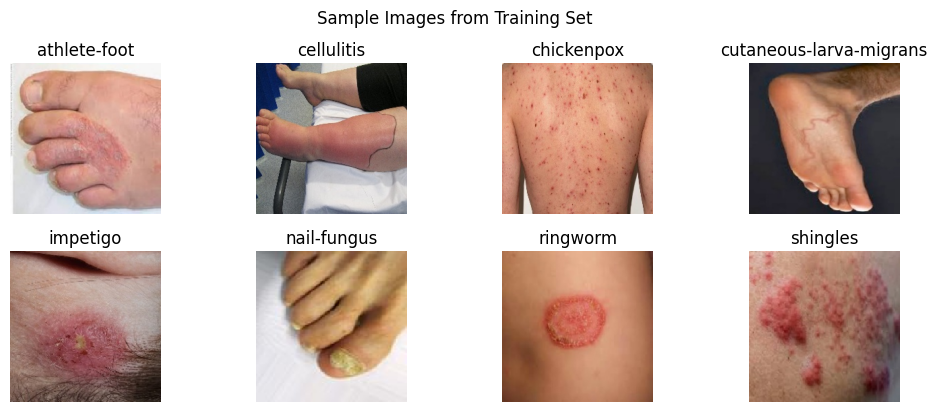

In [34]:
def display_sample_images(generator, class_names, title="Sample Images"):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):  # Loop through each class
        # Find the first occurrence of an image for the class
        class_indices = np.where(generator.classes == i)[0]
        if len(class_indices) == 0:
            continue  # Skip if no images are found for the class
        img_idx = class_indices[0]  # Get the first image index for the class
        
        # Get the image and label
        img, label = generator[img_idx // generator.batch_size]  # Batch lookup
        img = img[img_idx % generator.batch_size]  # Extract image from the batch

        # Plot the image
        plt.subplot(4, 4, i+1) 
        plt.imshow(img)
        plt.title(class_names[i])
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator, class_names, "Sample Images from Training Set")


Class Names: ['athlete-foot', 'cellulitis', 'chickenpox', 'cutaneous-larva-migrans', 'impetigo', 'nail-fungus', 'ringworm', 'shingles']


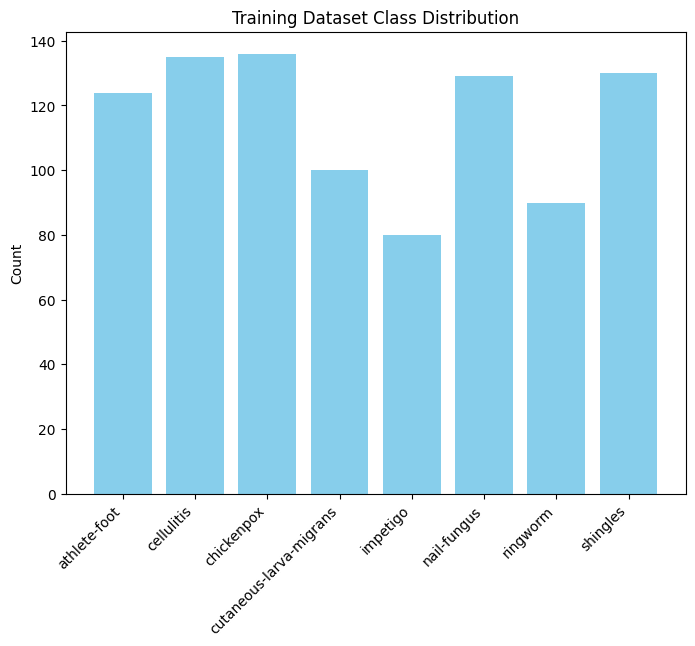

In [28]:
from collections import Counter
import matplotlib.pyplot as plt 

# Analyze the dataset
train_class_counts = Counter(train_generator.classes)
test_class_counts = Counter(test_generator.classes)

# Dataset class names
class_names = list(train_generator.class_indices.keys())  # Mapping of labels to disease names
print("Class Names:", class_names)

# Plot dataset distribution
def plot_dataset_distribution(class_counts, class_names, title):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_counts.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel("Count")
    plt.show()

plot_dataset_distribution(train_class_counts, class_names, "Training Dataset Class Distribution")

### Feature Extraction

In [8]:
# Load pretrained model (MobileNet) for feature extraction
base_model = tf.keras.applications.MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the model

In [11]:
# Extract features
def extract_features(generator, model):
    features = model.predict(generator)
    return features.reshape(features.shape[0], -1)

print("Extracting train features...")
X_train = extract_features(train_generator, base_model)
y_train = train_generator.classes

print("Extracting test features...")
X_test = extract_features(test_generator, base_model)
y_test = test_generator.classes

Extracting train features...
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step
Extracting test features...
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


### Training SVM

In [12]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
print("Training SVM classifier...")
svm_classifier.fit(X_train_scaled, y_train_encoded)

Training SVM classifier...


SVC(kernel='linear', probability=True, random_state=42)

### Evaluating the Model

In [15]:
# Evaluate on test data
y_pred = svm_classifier.predict(X_test_scaled)

In [16]:
# Convert numeric labels to disease names
y_pred_classes = label_encoder.inverse_transform(y_pred)
y_test_classes = label_encoder.inverse_transform(y_test_encoded)

In [17]:
from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 95.28%


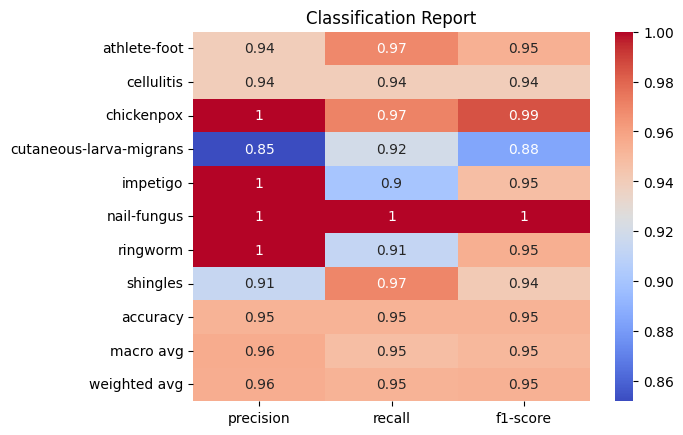

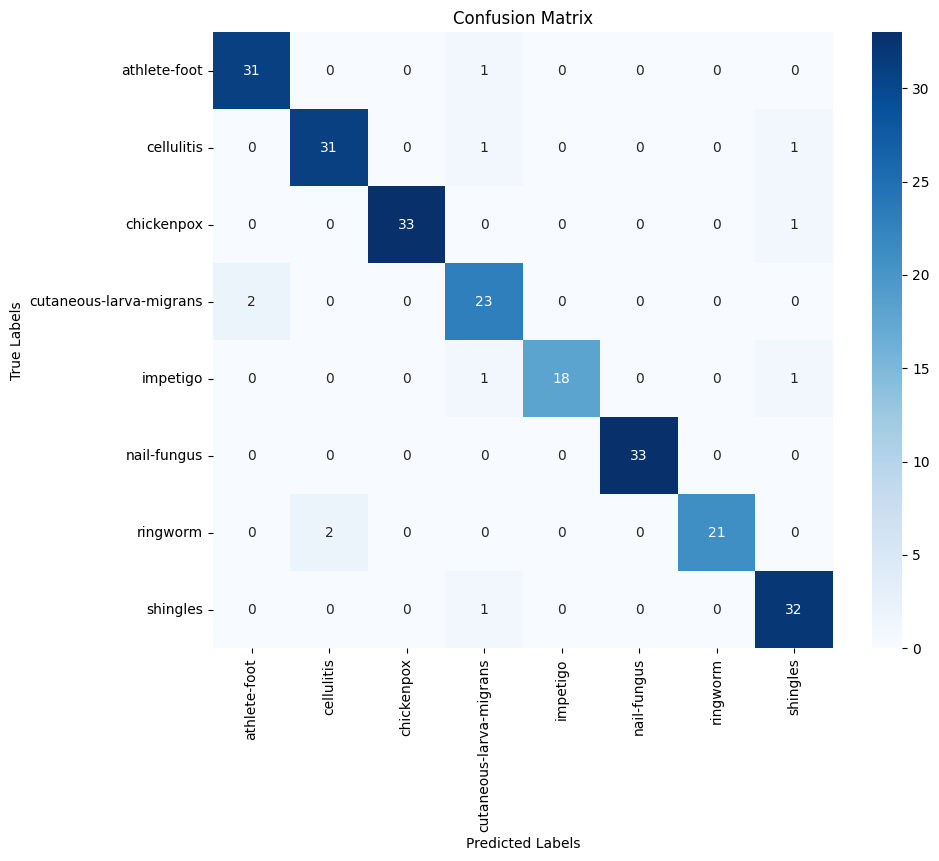

In [31]:
import seaborn as sns

# Convert numeric labels to disease names
y_pred_classes = [class_names[label] for label in y_pred]
y_test_classes = [class_names[label] for label in y_test_encoded]

# Classification Report Visualization
def plot_classification_report(y_test, y_pred, class_names):
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="coolwarm")
    plt.title("Classification Report")
    plt.show()

# Generate classification report heatmap
plot_classification_report(y_test_classes, y_pred_classes, class_names)


# Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

cm = confusion_matrix(y_test_classes, y_pred_classes, labels=class_names)
plot_confusion_matrix(cm, class_names)


In [32]:
import pickle

# Save the trained MobileNet model (base_model)
MODEL_PATH = "C:/Users/Abhijeet/Downloads/ASDP/mobilenet_model.h5"
print("Saving MobileNet model...")
base_model.save(MODEL_PATH)

# Save the SVM classifier
SVM_PATH = "C:/Users/Abhijeet/Downloads/ASDP/svm_classifier.pkl"
print("Saving SVM classifier...")
with open(SVM_PATH, "wb") as f:
    pickle.dump(svm_classifier, f)

# Save the StandardScaler
SCALER_PATH = "C:/Users/Abhijeet/Downloads/ASDP/scaler.pkl"
print("Saving StandardScaler...")
with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)

# Save the LabelEncoder
LABEL_ENCODER_PATH = "C:/Users/Abhijeet/Downloads/ASDP/label_encoder.pkl"
print("Saving LabelEncoder...")
with open(LABEL_ENCODER_PATH, "wb") as f:
    pickle.dump(label_encoder, f)

print("All components saved!")


Saving MobileNet model...
Saving SVM classifier...
Saving StandardScaler...
Saving LabelEncoder...
All components saved!
